In [1]:
include("./tools.jl")
using Plots
using Distributed

In [2]:
spawn(10)
@everywhere begin
    include("./tools.jl")
    unitcell = Lattice([0, 0]; vectors=[[1, 0],[0, 1]])
    cluster = Lattice(unitcell,(2,2),('p','p'))
    hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
    bs = Sector(hilbert, ParticleNumber(4))
    t = Hopping(:t, -1.0, 1)
    U = Hubbard(:U, 8.0)
    μ = Onsite(:μ, -1.0)
    origiterms = (t, U, μ)
    t_r = Hopping(:t, -1.0, 1)
    μ_r = Onsite(:μ_r, -1.0)
    referterms = (t_r, U, μ_r)
    neighbors = Neighbors(0=>0.0, 1=>1.0)
    rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
    vca = VCA(:N, unitcell, cluster, hilbert, origiterms, referterms, bs; neighbors=neighbors, m=200)
    gps(x) = GrandPotential((μ=x[1],), (μ_r=x[2],), :f, vca, rz, 0.0)
    els(x) = OrderParameters((μ=x[1],), (μ_r=x[2],), :f, vca, rz, 0.0)
    M = range(-1.8, -1.0, 10)
    options = Optim.Options(x_tol=1e-4, f_tol=1e-6, iterations=100)
end


In [12]:
res = pmap(m -> optimize(x->-gps([m, x...]), [-2.0], options), M)
mus = [re.minimizer for re in res]

10-element Vector{Vector{Float64}}:
 [-1.7981445312500002]
 [-1.7114990234374998]
 [-1.7289352416992192]
 [-1.7545837402343754]
 [-1.7841003417968748]
 [-1.823435974121094]
 [-1.8740783691406255]
 [-1.9078201293945312]
 [-1.937872314453125]
 [-1.9654846191406246]

In [13]:
unitcell = Lattice([0, 0]; vectors=[[1, 0],[0, 1]])
cluster = Lattice(unitcell,(2,2),('p','p'))
hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
bs = Sector(hilbert, SpinfulParticle(4, 0.0))
t = Hopping(:t, -1.0, 1)
U = Hubbard(:U, 8.0)
μ = Onsite(:μ, -1.1)
origiterms = (t, U, μ)
t_r = Hopping(:t, -1.0, 1)
μ_r = Onsite(:μ_r, -1.1)
referterms = (t_r, U, μ_r)
neighbors = Neighbors(0=>0.0, 1=>1.0)
rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
vca = VCA(:N, unitcell, cluster, hilbert, origiterms, referterms, bs; neighbors=neighbors, m=200)
ops = pmap(i->OrderParameters((μ=M[i],), (μ_r=mus[i][1],), :f, vca,hilbert, rz, μ, 0.0), 1:10)


10-element Vector{Float64}:
 1.0001877694629042
 0.9999607441028012
 0.9844107790572537
 0.9676546220520889
 0.9497009868639137
 0.925781024083851
 0.8883739009754259
 0.8654997396414191
 0.8455235047202811
 0.8268323626266757

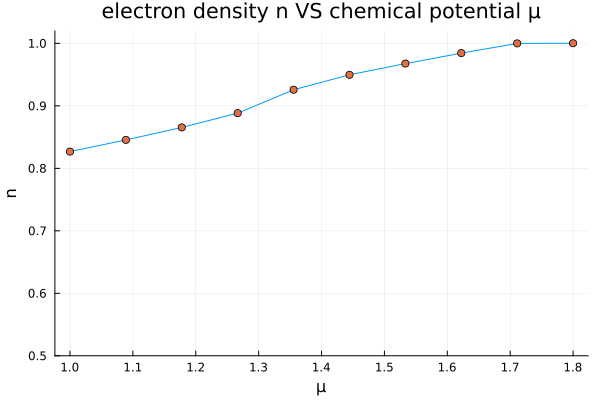

In [26]:
plot(range(1.0,1.8,10), reverse(ops),label=nothing,xticks = (1.0:0.1:1.8, [string(x) for x in 1.0:0.1:1.8]),xlabel="μ", ylabel="n",title="electron density n VS chemical potential µ")
scatter!(range(1.0,1.8,10), reverse(ops),label=nothing)
ylims!(0.5, 1.02)

